## There are two crucial stages for this bit. 

#### Firstly we need to be able to get the letters from the identity into their own boxes. Here you see an example, but its not so robust right now. 
#### Then we take 2 models trained, one trained on the relevant letters and one trained on the numbers (there are good publically available datasets) and predict. 

In [15]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
from image import *
import csv  
from io import BytesIO
from IPython import display

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *

from corrections import *
from image import * 
from handling import *

In [11]:
def extract_vertices(bounding_box):
    vertices = []
    for vertex in bounding_box.vertices:
        vertices.append((vertex.x, vertex.y))
    return vertices



def combine_paraboxes(para_boxes):
    bottom_left = para_boxes[:,0]
    bottom_right = para_boxes[:,1]
    top_right = para_boxes[:,2]
    top_left = para_boxes[:,3]

    para_box = np.zeros((4,2), dtype=np.int32)

    para_box[0] = np.min(bottom_left, axis=0)
    para_box[1] = np.max(bottom_right[:,0]),np.min(bottom_right[:,1])
    para_box[2] = np.max(top_right,axis=0)
    para_box[3] = np.min(top_left[:,0]),np.max(top_left[:,1])

    return para_box

def rotate_image_and_transform_coordinates(image, coordinates, angle):

    angle = np.rad2deg(angle)

    # Calculate the transformation matrix.
    transform_matrix = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)

    # Apply the transformation matrix to the coordinates.
    image = cv2.warpAffine(image, transform_matrix, (image.shape[1], image.shape[0]))

    transformed_coordinates = [(transform_matrix[:,:2] @ coordinates[i].T).T + transform_matrix[:,2] for i in range(len(coordinates))]

    return image, transformed_coordinates

def zero_printed_text(image, threshold=40, verbose=False):

    mask = np.zeros(image.shape, dtype=np.uint8)

    mask[(image>0) & (image<threshold)] = 1

    nx, ny = image.shape

    # mask[nx//6:4*nx//6, ny//6:5*ny//6] = 0 #havent worked this bit out yet

    dilated = cv2.dilate(mask, np.ones((9,9), np.uint8), iterations=1)



    return image * (1-dilated)


In [77]:
def GetImageAndParaBox(file, client, verbose=False):
    client = vision.ImageAnnotatorClient()
    whole_image = RetreiveImage(file, verbose=False)

    img_byte_array = CroppedImage(whole_image, verbose=False)

    decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
    frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

    content = img_byte_array.getvalue()
    image = vision.Image(content=content)

    response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

    character = []
    character_params = []

    for a, page in enumerate(response.full_text_annotation.pages):
        for b, block in enumerate(page.blocks):

            for c, paragraph in enumerate(block.paragraphs):
                
                for d, word in enumerate(paragraph.words):
                    for e, symbol in enumerate(word.symbols):

                        character.append(symbol.text)

                        character_params.append([a, b, c, d, e])


                        if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


    character_params = np.array(character_params)

    # If we have not read enough characters, the label may be moved outside the cropping box. Resort to reading the whole image and reducing.
    if len(character) < 7:
        if verbose: print('running with whole image')

        client = vision.ImageAnnotatorClient()
        content = whole_image.getvalue()
        image = vision.Image(content=content)
        response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        decoded = np.fromstring(whole_image.getvalue(), dtype=np.uint8)
        frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

        # content = img_byte_array.getvalue()
        # image = vision.Image(content=content)

        # response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        character = []
        character_params = []

        for a, page in enumerate(response.full_text_annotation.pages):
            for b, block in enumerate(page.blocks):

                for c, paragraph in enumerate(block.paragraphs):
                    
                    for d, word in enumerate(paragraph.words):
                        for e, symbol in enumerate(word.symbols):

                            character.append(symbol.text)

                            character_params.append([a, b, c, d, e])


                            if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


        character_params = np.array(character_params)

    lead_character = character[0]
    while lead_character != 'F' and lead_character != 'M':
        if verbose: print('removing character', character[0])
        character = character[1:]
        character_params = character_params[1:]
        if verbose: print('Reduced characters are now:', character)
        lead_character = character[0]
        if verbose: print('Lead character is now:', lead_character)

    if verbose: print('character in position 5:', character[5])

    page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.

    # 5th character bounding box is:
    character_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)
    character_height = character_bounds[0][1]

    # Vertices for remaining letters
    ID_vertices = []
    ID_vertices.append(character_bounds)

    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                for symbol in word.symbols:
                    vertices = extract_vertices(symbol.bounding_box)
                    if (character_height - (character_height / 5)) <= vertices[0][1] <= (character_height + (character_height / 5)):
                        ID_vertices.append(np.array(vertices))

    para_boxes = np.array(ID_vertices)
    para_box = combine_paraboxes(para_boxes)

    plt.imshow(frame)

    return frame, para_box

# def GetImageAndParaBox(file, client, verbose=False):
#     '''
#     retrieve the image along with a box that includes the ID.
#     '''
#     # import time
#     # tic = time.time()

#     image = RetreiveImage(file, verbose=False)
#     # print('RetreiveImage:', time.time()-tic)

#     img_byte_array = CroppedImage(image, verbose=False)

#     decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
#     frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 


#     content = img_byte_array.getvalue()
#     image = vision.Image(content=content)

#     response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})
    
#     character = []
#     character_params = []

#     for a, page in enumerate(response.full_text_annotation.pages):
#         for b, block in enumerate(page.blocks):

#             for c, paragraph in enumerate(block.paragraphs):
                
#                 for d, word in enumerate(paragraph.words):
#                     for e, symbol in enumerate(word.symbols):

#                         character.append(symbol.text)

#                         character_params.append([a, b, c, d, e])


#                         if verbose: print(character[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))


#     character_params = np.array(character_params)

#     if len(np.unique(character_params[:,2])) != 1: #if theres more than one paragraph, then the ID is split across >2 words.
        
#             page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.

#             para_boxes = np.array([np.array(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[i].bounding_box)) for i in range(len(page.blocks[block_no].paragraphs[paragraph_no].words))])
#             para_box = combine_paraboxes(para_boxes)

#     else:
#         no_words = len(np.unique(character_params[:,3]))
#         if no_words==3:
#             page_no, block_no, paragraph_no, word_no, symbol_no = character_params[5] #take the 5th character and use the words boudning box.

#             para_box = np.array(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].bounding_box))
        

#         else: #this means that the ID has been split across two words annoyingly.


#             #discard title and date
#             character_params = character_params[(character_params[:,3]!=0) & (character_params[:,3]!=np.max(character_params[:,3]))] 
            
#             uniwords = np.unique(character_params[:,3])

#             para_boxes = np.array([np.array(extract_vertices(page.blocks[character_params[0,1]].paragraphs[character_params[0,2]].words[uniwords[i]].bounding_box)) for i in range(len(uniwords))])


#             #now need to combine the words. 
#             if not all(np.abs(para_boxes[0,:,1] - para_boxes[1,:,1]) < 200): #check the y coordinates
#                 raise ValueError('check they are actually same word.')
            
#             para_box = combine_paraboxes(para_boxes)

#     return frame, para_box


In [24]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 60
    pady = 40

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])


    adapted_para_box[x[:2],0] = np.max( np.stack(( paragraph_vertices[x[:2],0] - padx , [0,0] )), axis=0)

    adapted_para_box[x[2:],0] = np.min( np.stack(( paragraph_vertices[x[2:],0] + 1.2*padx , [frame.shape[1],frame.shape[1]] )), axis=0)

    adapted_para_box[y[:2],1] = np.max( np.stack(( paragraph_vertices[y[:2],1] - pady, [0,0] )), axis=0) 
    adapted_para_box[y[2:],1] = np.min( np.stack(( paragraph_vertices[y[2:],1] + pady , [frame.shape[0],frame.shape[0]])), axis=0)


    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,5,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    return frame


/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_50589/1523887146.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


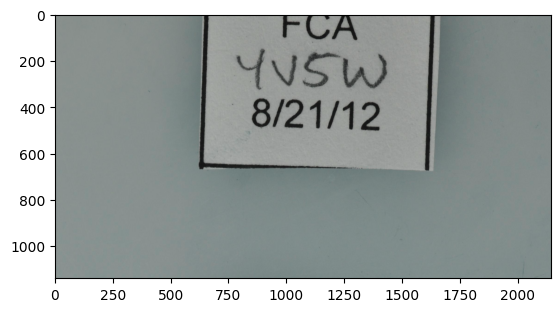

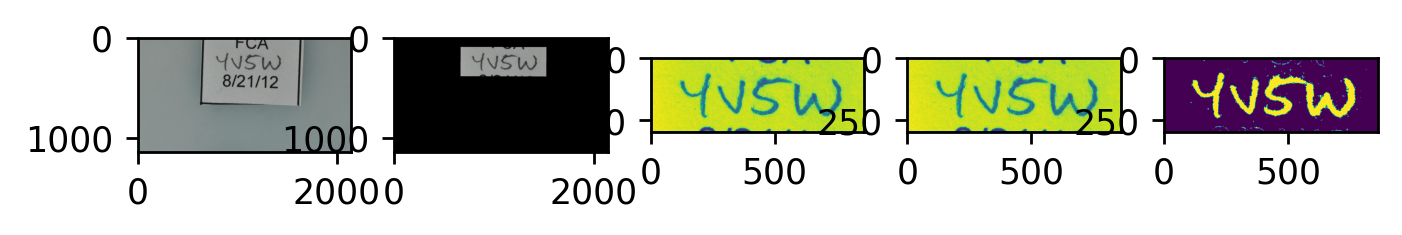

In [6]:
file = 'Manually_Labelled/New/CA1208/FCA4V5W1208.JPG'
client = vision.ImageAnnotatorClient()
frame, para_box = GetImageAndParaBox(file, client)

%matplotlib inline
ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [38]:
folders = ['Manually_Labelled/New/CA1208', 'Manually_Labelled/New/CA1207' ,'Manually_Labelled/New/CA1206','Manually_Labelled/New/CA1209jpegs JB']

bucket_name = "guppy_images"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)

file_list = []
for folder in folders:
    s_file_list = storage_client.list_blobs(bucket_name,prefix=folder)
    s_file_list = [file.name for file in s_file_list]
    file_list.extend(s_file_list)

In [39]:
def extract_ID(file_list):
    
    id_list = []
    for f in file_list:
        f = f.split('/')[-1].split('.')[0]

        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

In [40]:
IDs = np.array(extract_ID(file_list))

/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_49643/1523887146.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
3 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
√ pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
7 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
4 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
8 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
/ pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
2 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
1 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:3
/ pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:4
1 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:5
2 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:6


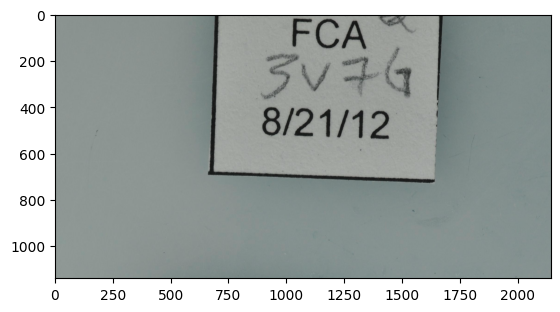

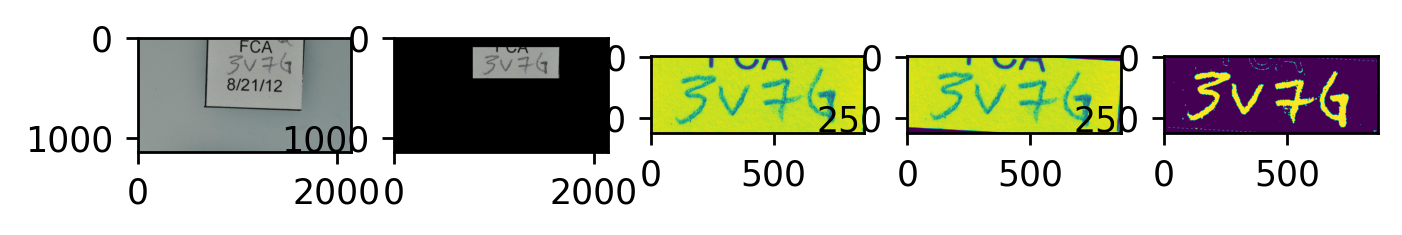

In [41]:
frame, para_box = GetImageAndParaBox(file_list[78], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)
label_ID = IDs[78]

In [42]:
image_width, image_height = 256, 64

In [43]:
characters = []
for i in IDs:
    for j in i:
        if j not in characters:
            characters.append(j)

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

max_len = len(max(IDs, key=len))

In [44]:
model = tf.keras.Sequential()
model.add(char_to_num)
model.add(num_to_char)
model.build(input_shape=(1,1))
model.save('stringlookups.h5') #need to save these lookup tables for use in model.

/Users/jordan/anaconda3/envs/Guppies/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
model = tf.keras.models.load_model('stringlookups.h5');

char_to_num = model.layers[0]
num_to_char = model.layers[1]

In [46]:
vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

array([[14,  9, 11,  8,  1, 99, 99, 99]])

In [47]:
# h5f.close()
h5f = h5py.File(('dataset.h5'), 'w')

image_width, image_height = 256, 64
   
first_image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
first_label = vectorize_label(label_ID, char_to_num, max_len=max_len, padding_token=99).numpy()[None]

h5f.create_dataset('images', data=first_image, compression="gzip", chunks=True, maxshape=(None,image_height,image_width))
h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,max_len))


<HDF5 dataset "labels": shape (1, 8), type "<i8">

In [48]:
# some_im_IDs = []
# some_label_IDs = []

idx = np.arange(0, len(file_list))
np.random.shuffle(idx)


for i in range(len(file_list)):
    st = str(i)
    try: 
        frame, para_box = GetImageAndParaBox(file_list[idx[i]], client = client, verbose=False)
        im_ID = extract_ID_handwriting(frame, para_box, verbose=False)


        image = preprocess_image(im_ID[...,None],(image_width,image_height)).numpy()[None,...,0]
        label = vectorize_label(IDs[idx[i]], char_to_num, max_len=max_len, padding_token=99).numpy()[None]

        h5f['images'].resize((h5f['images'].shape[0] + 1),axis=0)
        h5f['images'][-1:] = image

        h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
        h5f['labels'][-1:] = label

        # some_im_IDs.append(im_ID)
        # some_label_IDs.append(IDs[idx[i]])
        st += ' success'

    except: st += ' fail'
    print(st)

h5f.close()
    

/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_49643/1523887146.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
16 success
17 success
18 success
19 success
20 success
21 success
22 success
23 success
24 success
25 success
26 success
27 success
28 success
29 success
30 success
31 success
32 success
33 success
34 success
35 success
36 success
37 success
38 success
39 success
40 success
41 success
42 success
43 success
44 success
45 success
46 success
47 success
48 success
49 success
50 success
51 success
52 success
53 success
54 success
55 success
56 success
57 success
58 success
59 success
60 success


61 success


C:\Users\howards\AppData\Local\Temp\ipykernel_10364\3994686233.py:21: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)


V pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
M pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:0
C pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:1
A pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:2
6 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:0
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:1
7 pageno:0 blockno:1 paragraphno:0 wordno:1 symbolno:2
V pageno:0 blockno:1 paragraphno:0 wordno:2 symbolno:0
8 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:0
/ pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:1
2 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:2
1 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:3
/ pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:4
1 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:5
2 pageno:0 blockno:1 paragraphno:0 wordno:3 symbolno:6


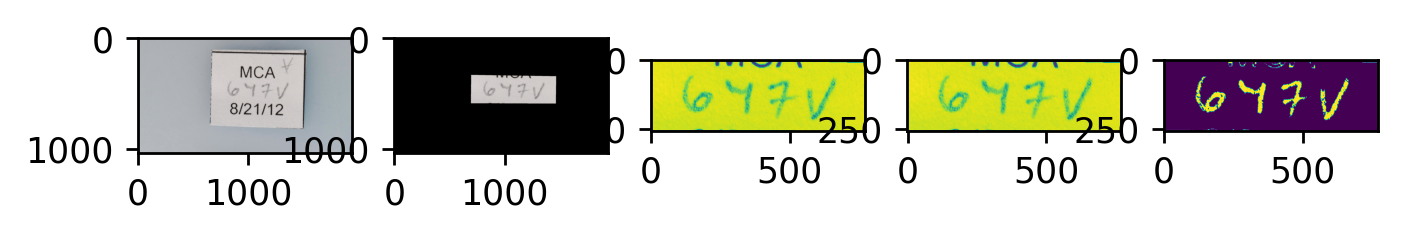

In [ ]:
frame, para_box = GetImageAndParaBox(file_list[209], client = client, verbose=True)

im_ID = extract_ID_handwriting(frame, para_box, verbose=True)

In [16]:
new_files = ListAvaliableFiles("guppy_images", "Manually_Labelled/New")
new_jpg_files = [ x for x in new_files if "JPG" in x ]

np.random.shuffle(new_jpg_files)

/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_50589/4202135713.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_50589/4202135713.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(whole_image.getvalue(), dtype=np.uint8)


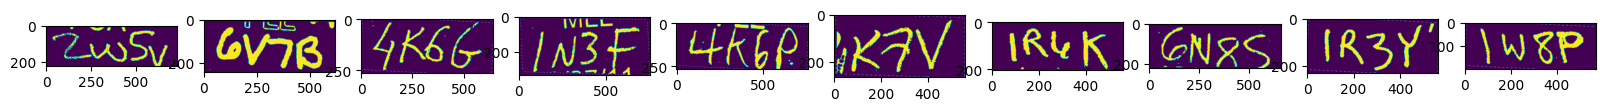

In [83]:
fig,ax = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    frame, para_box = GetImageAndParaBox(new_jpg_files[60 + i], client, verbose=False)
    ID = extract_ID_handwriting(frame, para_box, verbose=False)
    ax[i].imshow(ID)

In [47]:
new_jpg_files[62]

'Manually_Labelled/New/TY1003/MTY4K6G1003DUP.JPG'

/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_50589/4202135713.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(img_byte_array.getvalue(), dtype=np.uint8)
/var/folders/g6/vf66khg95zd_3tvhzw_zn6fm0000gn/T/ipykernel_50589/4202135713.py:45: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  decoded = np.fromstring(whole_image.getvalue(), dtype=np.uint8)


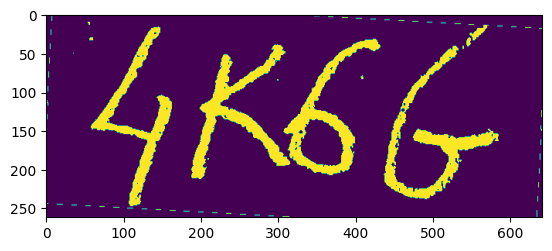

In [80]:
frame, para_box = GetImageAndParaBox(new_jpg_files[62], client, verbose=False)
ID = extract_ID_handwriting(frame, para_box, verbose=False)
plt.imshow(ID)